In [2]:
!pip install nltk
#!pip install spacy
!python -m nltk.downloader averaged_perceptron_tagger
!pip install --upgrade nltk
!pip install transformers
!pip install torch torchvision
!pip install --upgrade diffusers accelerate transformers
# !pip install controlnet_aux


  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
  Using cached transformers-4.47.0-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.26.5-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.4.5-cp311-cp311-m

In [24]:
!pip install -q diffusers transformers accelerate invisible-watermark>=0.2.0

In [61]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import gutenberg
#from nltk import pos_tag
import random
#import spacy
from transformers import pipeline


# PROMPT GENERATION

## Random words

In [62]:
# Download the WordNet dataset
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [63]:
# Backups
nouns = list(wn.all_synsets('n'))
adjectives = list(wn.all_synsets('a'))
verbs = list(wn.all_synsets('v'))
#random_noun = random.choice(nouns).lemmas()[0].name()
#random_adjective = random.choice(adjectives).lemmas()[0].name()
#random_verb = random.choice(verbs).lemmas()[0].name()

In [64]:
random.seed(13)
prompt_length = 10
prompt_wordnet = []
for x in range(prompt_length):
    x = random.choice(nouns).lemmas()[0].name()
    prompt_wordnet.append(x)

In [65]:
prompt_wordnet

['radiogram',
 'prelude',
 'switch',
 'pituitary',
 'hobby',
 'iliolumbar_artery',
 'tender',
 'cummerbund',
 'tinamou',
 'Endomycetales']

## Random words from famous artists

In [3]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /home/jovyan/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [4]:
book_complete = gutenberg.words('austen-emma.txt')
austen_emma = ' '.join([word for word in book_complete if word.isalpha()])

In [5]:
nltk.data.path.append("/home/jovyan/nltk_data")  # Ensure the correct path is used
nltk.download('punkt')

nltk.download('averaged_perceptron_tagger', download_dir='/home/jovyan/nltk_data')
nltk.download('punkt_tab')  # This will download the missing tokenizer files

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
pipe = pipeline("token-classification", model="vblagoje/bert-english-uncased-finetuned-pos", device=0)

Some weights of the model checkpoint at vblagoje/bert-english-uncased-finetuned-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def prompt_generation(text):

    def chunk_text(text, max_length=512):
        words = text.split()  # Split text into words
        chunks = []
        current_chunk = []
    
        # Iterate over words and form chunks
        for word in words:
            if len(" ".join(current_chunk + [word])) <= max_length:
                current_chunk.append(word)
            else:
                chunks.append(" ".join(current_chunk))
                current_chunk = [word]
                
        # Add the last chunk if it exists
        if current_chunk:
            chunks.append(" ".join(current_chunk))
        return chunks
        
    # Chunk the input text
    chunks = chunk_text(text)
    
    # Initialize lists to store words by POS
    nouns = []
    verbs = []
    adjectives = []
    
    # Process each chunk and classify POS
    for chunk in chunks:
        word_classification = pipe(chunk)
        
        for word in word_classification:
            pos = word.get('entity')
            word_text = word.get('word')
            
            if pos == 'NOUN':
                nouns.append(word_text)
            elif pos == 'VERB':
                verbs.append(word_text)
            elif pos == 'ADJ':
                adjectives.append(word_text)
                
    # Filter out tokenized words starting with ##
    nouns = [word for word in nouns if not word.startswith("##")]
    verbs = [word for word in verbs if not word.startswith("##")]
    adjectives = [word for word in adjectives if not word.startswith("##")]

    # Check if lists are non-empty before selecting random words
    prompt_components = []
    
    if adjectives:
        prompt_components.append(random.choice(adjectives))
    if nouns:
        prompt_components.append(random.choice(nouns))
    if verbs:
        prompt_components.append(random.choice(verbs))
    if adjectives:
        prompt_components.append(random.choice(adjectives))
    if nouns:
        prompt_components.append(random.choice(nouns))
    
    # Join the prompt components
    prompt = ' '.join(prompt_components)
    
    return prompt


In [9]:
random.seed(15)

prompt = prompt_generation(austen_emma)
prompt

'contrary subject hearing small law'

# IMAGE GENERATION

## N°1

In [82]:
import requests
from PIL import Image, ImageOps, ImageDraw
from io import BytesIO
#from diffusers import StableDiffusionPipeline
#from diffusers import StableDiffusionUpscalePipeline
#from diffusers import StableDiffusionImg2ImgPipeline
import torch
from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline
from diffusers import AutoPipelineForText2Image
from diffusers import AutoPipelineForImage2Image
#from diffusers.utils import load_image, make_image_grid


In [83]:
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")

refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [84]:
txt_2_img_pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [85]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

torch.cuda.synchronize() 

In [86]:
# HARD CODED TO DELETE
#prompt = 'contrary subject hearing small law'
#negative_prompt = 'blurry, text, letters, typography, writing, low resolution, watermark, patterns, distorted face, bad anatomy, uncanny, extra fingers, missing fingers, missing faces, pixelated, deformed'
#words = prompt_wordnet
negative_prompt = 'blurry, text, letters, typography, writing, low resolution, watermark, patterns, distorted face, bad anatomy, uncanny, extra fingers, missing fingers, missing faces, pixelated, deformed, no text'
positive_prompt = 'clean lines, well-balanced composition'

In [89]:
def first_img(word):
    #words = prompt.split()
    image_1 = txt_2_img_pipe(word + positive_prompt, 
                             negative_prompt=negative_prompt, 
                             guidance_scale=13, 
                             num_inference_steps=80, 
                             height=1024, 
                             width=1024).images[0]
    image_1.save(f'image_{word}.png')
    
    # Show the image
    print(word)
    return image_1


In [90]:
austen_01 = ['contrary', 'subject', 'hearing', 'small', 'law']

first_img(austen_01[0])

  0%|          | 0/80 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.00 MiB. GPU 

## IMG 2 IMG

In [53]:
# use from_pipe to avoid consuming additional memory when loading a checkpoint
img2img_pipe = AutoPipelineForImage2Image.from_pipe(txt_2_img_pipe).to("cuda")


### Gif maker iterating with the entire prompt
Could be with several different prompt as well and/or poems

strength = 0.8  # How much the original image is preserved
guidance_scale = 7 # How closely the image should match the prompt

# Set the initial image as the starting point
current_image = Image.open("image_1.png").convert("RGB")

# Iterate over each word in the prompt
for i in range(1, len(words)):

    output = img2img_pipe(
        prompt= words[i] + positive_prompt,  
        negative_prompt=negative_prompt,
        image=current_image, 
        strength=strength,
        guidance_scale=guidance_scale
    ).images[0]

    # Save the current output image
    output_filename = f"output_full_prompt_{i+1}_{words[i]}.jpg"
    output.save(output_filename)
    
    # Use the current output image as the input for the next iteration
    current_image = output

    print(f"Saved image: {output_filename}")

In [54]:
def gif_img_generator(img_path, strength, guidance_scale, words):
    
    # Set the initial image as the starting point
    current_image = Image.open(img_path).convert("RGB")
    
    # Iterate over each word in the prompt
    for i in range(1, len(words)):
    
        output = img2img_pipe(
            prompt= words[i] + positive_prompt,  
            negative_prompt=negative_prompt,
            image=current_image, 
            strength=strength, # How much the original image is preserved
            guidance_scale=guidance_scale # How closely the image should match the prompt
        ).images[0]
    
        # Save the current output image
        output_filename = f"gif_{i+1}_{words[i]}.jpg"
        output.save(output_filename)
        
        # Use the current output image as the input for the next iteration
        current_image = output
        print(f"Saved image: {output_filename}")

    print("Generation done.")
    return None

In [70]:
gif_img_generator("image_1.png", 0.8, 7, words)

  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_2_prelude.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_3_switch.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_4_pituitary.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_5_hobby.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_6_iliolumbar_artery.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_7_tender.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_8_cummerbund.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_9_tinamou.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_full_prompt_10_Endomycetales.jpg
Generation done.


### EXTEND IMAGE WITH NEXT WORD.
Input = previous image, next prompt word

In [162]:
def expand_img(input_img, word):
    input_img = Image.open(input_img).convert("RGB")
    expanded_size = ( input_img.width, input_img.height)
    top_part = input_img.crop((0, 0, input_img.width, input_img.height // len(words))
    top_part = top_part.resize(expanded_size)

    expanded_image = img2img_pipe(
    prompt=word + positive_prompt,
    negative_prompt=negative_prompt,
    image=top_part,
    strength=0.75,
    guidance_scale=7.5).images[0]
    return expanded_image



In [168]:
expanded_images = []
input_img = 'image_1.png'
for i in words[1:]:
    expanded = expand_img(input_img, i)
    expanded.save(f"expanded_{i}.png")
    expanded_images.append(expanded)  # Add each expanded image to the list


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [171]:
def merge_images(images):
    # Get the width and total height of the new image (stack images vertically)
    total_height = sum(image.height for image in images)
    width = images[0].width  # Assume all images have the same width

    # Create a new canvas to hold all images stacked vertically
    merged_image = Image.new("RGB", (width, total_height))

    # Paste each image into the canvas at the correct position
    current_height = 0
    for image in images:
        merged_image.paste(image, (0, current_height))
        current_height += image.height
    merged_png = merged_image.save(f"merged_{prompt}.png")
    return merged_image

In [172]:
final_merged_image = merge_images(expanded_images)


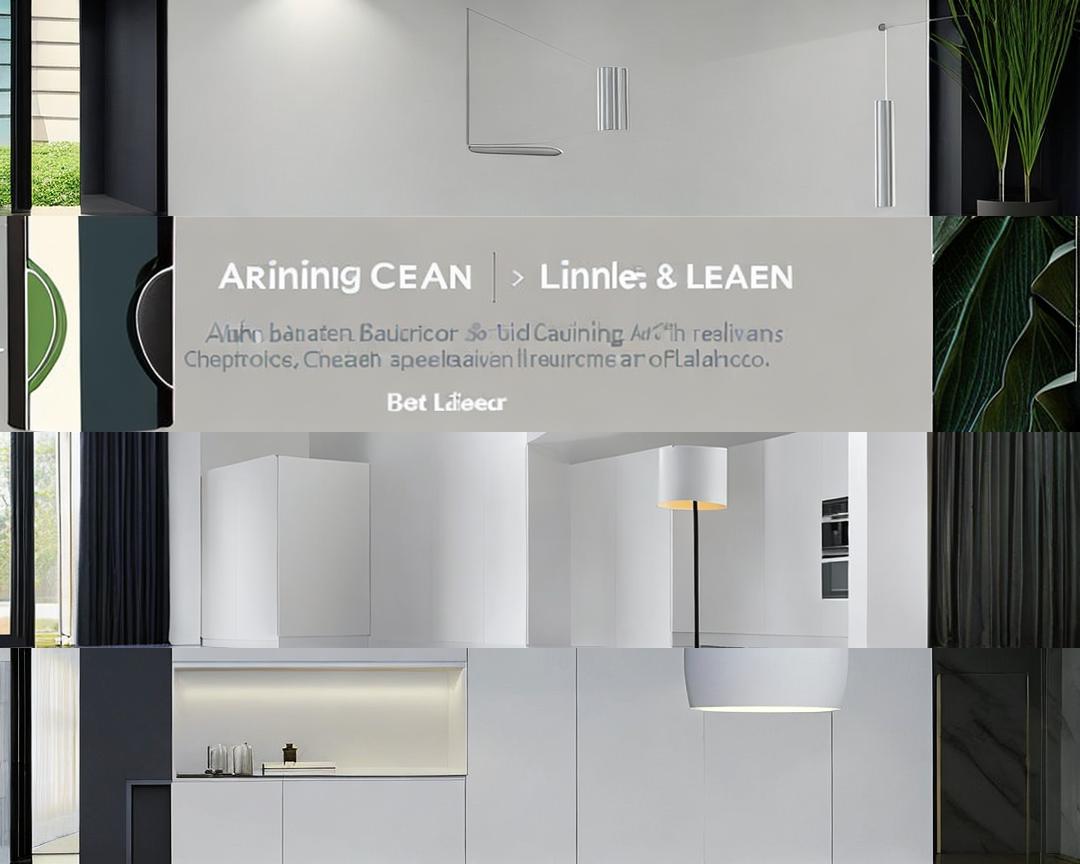

In [170]:
final_merged_image

In [90]:
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [61]:
# Pick an image from an image dataset rather than generating it? and make a collage?

In [55]:
# ETERNAL RIGHT SCROLL OR BOTTOM, ETC.
# Prompt[:1] --> image1 --> right part of image1 + prompt[1:2] + style of image1 and noise/random --> image2 --> right part of image2 + prompt[2:3] + style of image 1...

In [ ]:
# ZOOM OUT OF ZOOM IN
# prompt[:1] --> image1 --> image1 + zoom out (bigger picture) --> 

In [3]:
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import torch

# Load the pipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", 
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
# Give the path of your image
image_path = 'top_part.png'
# Read the image from the path
image = cv2.imread(image_path)
height, width = image.shape[:2]
padding = 100 # num pixels to outpaint
mask = np.ones((height+2*padding, width+2*padding), dtype=np.uint8) * 255
mask[padding:-padding, padding:-padding] = 0
cv2_imshow(mask)
cv2.imwrite("mask.png", mask)

# Reset

In [81]:
torch.cuda.empty_cache()
%reset -f
